
![Deep Learning Türkiye Uygulamalar](https://raw.githubusercontent.com/deeplearningturkiye/pratik-derin-ogrenme-uygulamalari/84354f5989730fc297ec5c6d247b1990632cc992/images/dltr_logo.png)

[Google Colab'da çalıştır!](https://colab.research.google.com/drive/1cj7AV3_eANmb3PsH47469vOGKduXW_jB#scrollTo=CgIWAkpk5P1k)

<h2>Hiyerarşik Devirli Sinir Ağları (Hierarchical Recurrent Neural Networks (HRNN))</h2>

---

MNIST dataseti üzerinde **Denoising Autoencoder (parazit arındıran otomatik kodlayıcı)** uyguluyor.
Parazit arındırma otomatik kodlayıcıların en klasik uygulama alanlarından birisidir.
Parazit arındırma süreci asıl sinyalleri bozan istenmeyen parazitlerden kurtulmayı sağlar.

*Parazit + Veri ---> Denoising Autoencoder ---> Veri*

Bozuk bir veri kümesini girdi, asıl veriyi çıktı olarak verdiğimizde Denoising Autoencoder
asıl veriyi elde etmek için gizli yapıyı kurtarır.

Bu örnek modüler dizayna sahip. Encoder (şifreleyici), Decoder (çözümleyici) ve Autoencoder
aynı ağırlık değerlerini (weight) paylaşan 3 ayrı modeldir. Örneğin, autoencoder eğitildikten
sonra, encoder girdi verisetinin örtülü vektörlerini (latent vectors) oluşturmak için 
kullanılabilir. Böylece PCA ve TSNE'nin yaptığı gibi küçük boyutta indirgeyerek görselleştirme 
yapılabilir.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(1337)

Using TensorFlow backend.


In [2]:
# Veriseti yükleniyor ve eğitim/test diye ayrılıyor.
(x_train, _), (x_test, _) = mnist.load_data()

11501568/11490434 [==============================] - 1s 0us/step


In [0]:
# Veri 4 boyutlu olarak yeniden şekillendiriliyor.
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [0]:
# MNIST verisine parazit katarak bozuyoruz. Bunun için
# 0.5 merkezinde std=0.5 olan bir normal frekans dağılımı ekliyoruz veriye.
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

# Parazit katılmış veriler 0 ile 1 arasını aşmayacak şekilde düzenleniyor.
# 0'dan küçük değerler 0'a, 1'den büyük değerler 1'e eşitleniyor.
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [0]:
# Model parametreleri
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16

# Encoder ve Decoder için CNN katmanları ve her katman için uygulanacak filtreler
# Burada 2 katman var. İlk katmanın filtre sayısı 32, ikincisinin 64.
layer_filters = [32, 64]

**Autoencoder Modelinin Kurulumu**

In [8]:
# Öncelikle Encoder modeli kuruluyor
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# Con2D blokları
# Not:
# 1) Derin ağlarda ReLU kullanmadan önce Batch Normalization kullanın
# 2) strides>1'a alternatif olarak MaxPooling2D kullanın
# - daha hızlı ama strides>1 kadar iyi değil
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# Decoder Modelini oluştururken lazım olan boyut bilgileri
shape = K.int_shape(x)

# Örtülü vektörün (Latent Vector) oluşturulması
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Encoder Modelinin örneklendirilmesi
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Decoder Modelinin oluşturulması
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Transpozu alınmış Conv2D blokları
# Not:
# 1) Derin ağlarda ReLU kullanmadan önce Batch Normalization kullanın
# 2) strides>1'a alternatif olarak UpSampling2D kullanın
# - daha hızlı ama strides>1 kadar iyi değil
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Decoder Modelinin örneklendirilmesi
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         289       
_________________________________________________________________
decoder_output (Activation)  (None, 28, 28, 1)         0         
Total para

In [10]:
# Autoencoder = Encoder + Decoder
# Autoencoder Modelinin örneklendirilmesi
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [0]:
autoencoder.compile(loss='mse', optimizer='adam')

In [12]:
# Autoencoder'ı eğitiyoruz bu adımda
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=30,
                batch_size=batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 126s 2ms/step - loss: 0.0661 - val_loss: 0.0365
Epoch 2/30
60000/60000 [==============================] - 127s 2ms/step - loss: 0.0275 - val_loss: 0.0222
Epoch 3/30
60000/60000 [==============================] - 126s 2ms/step - loss: 0.0211 - val_loss: 0.0196
Epoch 4/30
60000/60000 [==============================] - 126s 2ms/step - loss: 0.0192 - val_loss: 0.0183
Epoch 5/30
60000/60000 [==============================] - 127s 2ms/step - loss: 0.0181 - val_loss: 0.0176
Epoch 6/30
60000/60000 [==============================] - 132s 2ms/step - loss: 0.0175 - val_loss: 0.0174
Epoch 7/30
60000/60000 [==============================] - 135s 2ms/step - loss: 0.0171 - val_loss: 0.0170
Epoch 8/30
60000/60000 [==============================] - 135s 2ms/step - loss: 0.0167 - val_loss: 0.0169
Epoch 9/30
60000/60000 [==============================] - 136s 2ms/step - loss: 0.0164 - val_loss: 0.0

In [0]:
# Parazit eklenmiş test görsellerinin çıktılarını autoencoder ile tahmin ediyoruz
x_decoded = autoencoder.predict(x_test_noisy)

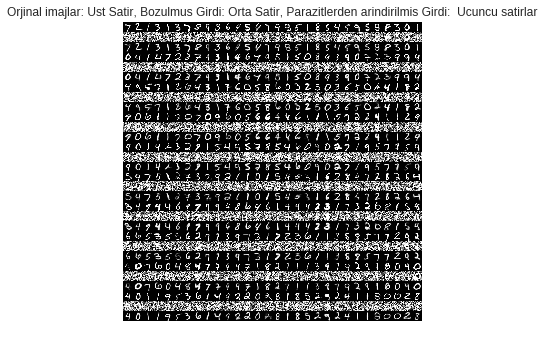

In [14]:
# İlk 8 parazit eklenmiş ve bozulmuş imajı görselliyoruz
rows, cols = 10, 30
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Orjinal imajlar: Ust Satir, '
          'Bozulmus Girdi: Orta Satir, '
          'Parazitlerden arindirilmis Girdi:  Ucuncu satirlar')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('bozulmus_ve_parazit_eklenmis.png')
plt.show()